In [3]:
from pathlib import Path

MAX_DATA_PATH = Path("C:/Users/maxpd/Desktop/483 ML/Intrusion Detection/483-final-project-datasets/OPCUA_dataset_public.csv")
CHRIS_DATA_PATH = Path("/Users/chriszinati/Desktop/CPSC-483/final project datasets/483-final-project-datasets/OPCUA_dataset_public.csv")

**Data Cleaning**
- delete rows with missing data
- get rid of noisy data (in our case, all non-ddos anomalies)
- drop the multiclass target label (since were only looking at ddos vs normal (1 or 0))
- dropped source and destination ip and port (useless features)

In [4]:
import pandas as pd
#Stops showing values in scientific notation
pd.set_option('display.float_format', lambda x: f'{x:.4f}')


#it isn't reading just the relative path for some reason, so use the whole path
df = pd.read_csv(CHRIS_DATA_PATH)
df = df.dropna(axis=0) #drop rows with missing values

instancesToDrop= ['MITM', 'Impersonation'] 
df = (df[df.multi_label.isin(instancesToDrop) == False]) #drop instances of MITM and Impersonation
df = df.drop('multi_label', axis=1) #drop multiclass label
df = df.drop('src_ip', axis=1) #drop source ip label
df = df.drop('src_port', axis=1) #drop source port label
df = df.drop('dst_ip', axis=1) #drop destination ip label
df = df.drop('dst_port', axis=1) #drop destination port label
print(df) #should be 107578 rows x 27 columns insetead of  107634 rows x 32 columns now



        flags  pktTotalCount  octetTotalCount   avg_ps  proto  \
0           1              2              219 109.5000  OPCUA   
1           1              2              219 109.5000  OPCUA   
2           1              2              399 199.5000  OPCUA   
3           1              2              399 199.5000  OPCUA   
4           1              2              219 109.5000  OPCUA   
...       ...            ...              ...      ...    ...   
107628      1              2              359 179.5000  OPCUA   
107629      1              2              358 179.0000  OPCUA   
107630      1              2              359 179.5000  OPCUA   
107631      1              2              359 179.5000  OPCUA   
107632      1              2              359 179.5000  OPCUA   

                   service  service_errors  status_errors  msg_size  \
0       StartRawConnection               0              0        87   
1       StartRawConnection               0              0        87   
2     

In [5]:
##Checking Correlation of all features to target label ONLY

Top features positively correlated with anomalies (label = 1):
service                        0.9992
count                          0.8238
srv_count                      0.8237
dst_host_same_src_port_rate    0.0422
same_srv_rate                  0.0419
f_pktTotalCount               -0.0045
flowDuration                  -0.0063
avg_flowDuration              -0.0200
flowInterval                  -0.0457
flowStart                     -0.3167
f_flowStart                   -0.3167
flowEnd                       -0.3167
f_octetTotalCount             -0.9842
msg_size                      -0.9938
pktTotalCount                 -0.9949
Name: label, dtype: float64

Top features negatively correlated with anomalies (label = 1):
flowEnd             -0.3167
f_octetTotalCount   -0.9842
msg_size            -0.9938
pktTotalCount       -0.9949
octetTotalCount     -0.9953
avg_ps              -0.9956
min_msg_size        -0.9962
b_octetTotalCount   -0.9964
f_rate              -0.9992
b_flowStart         -0.

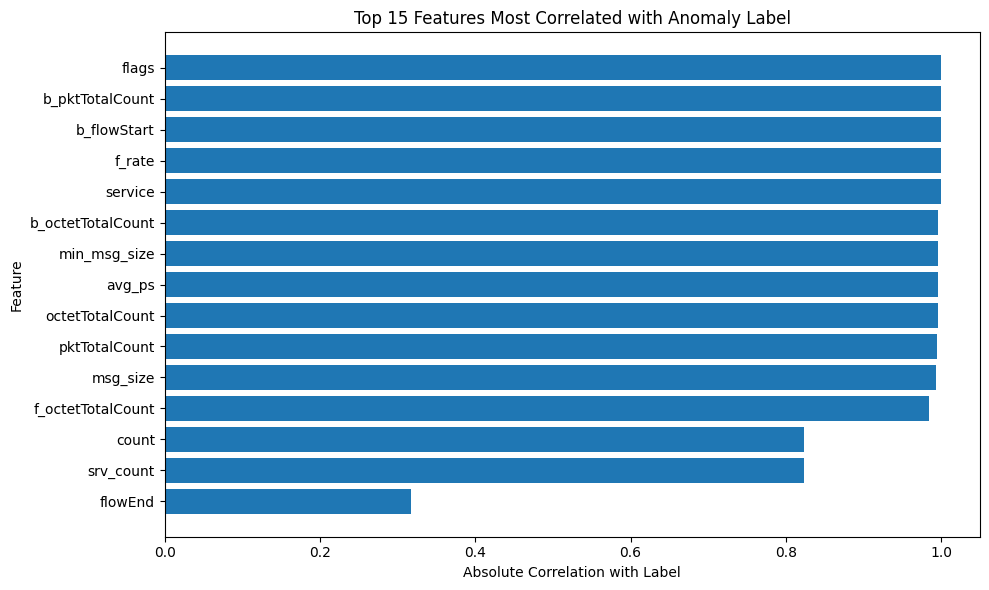

In [6]:
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder

for col in ['proto', 'service', 'service_errors', 'status_errors']:
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

correlation_matrix = df.corr()
correlation_with_label = correlation_matrix['label'].drop('label').sort_values(ascending = False)

print("Top features positively correlated with anomalies (label = 1):")
print(correlation_with_label.head(15))

print("\nTop features negatively correlated with anomalies (label = 1):")
print(correlation_with_label.tail(15))

top_corr = correlation_with_label.abs().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_corr.index, top_corr.values)
plt.gca().invert_yaxis()  # Highest on top
plt.title("Top 15 Features Most Correlated with Anomaly Label")
plt.xlabel("Absolute Correlation with Label")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [7]:
#Checking for range of all features incase normalization is needed
min_max_df = df.describe().loc[['min', 'max']].transpose().round(4)
print(min_max_df)


                                                 min                       max
flags                                         0.0000                    1.0000
pktTotalCount                                 1.0000                   17.0000
octetTotalCount                              86.0000                 3314.0000
avg_ps                                       86.0000                  490.5000
proto                                         0.0000                    0.0000
service                                       0.0000                    3.0000
service_errors                                0.0000                    0.0000
status_errors                                 0.0000                    0.0000
msg_size                                     32.0000                 2192.0000
min_msg_size                                 28.0000                  272.0000
flowStart                            1583854854.0882           1583862251.6785
flowEnd                              1583854854.0937

In [8]:
#Finding correlation between all features, checking for redudancy 

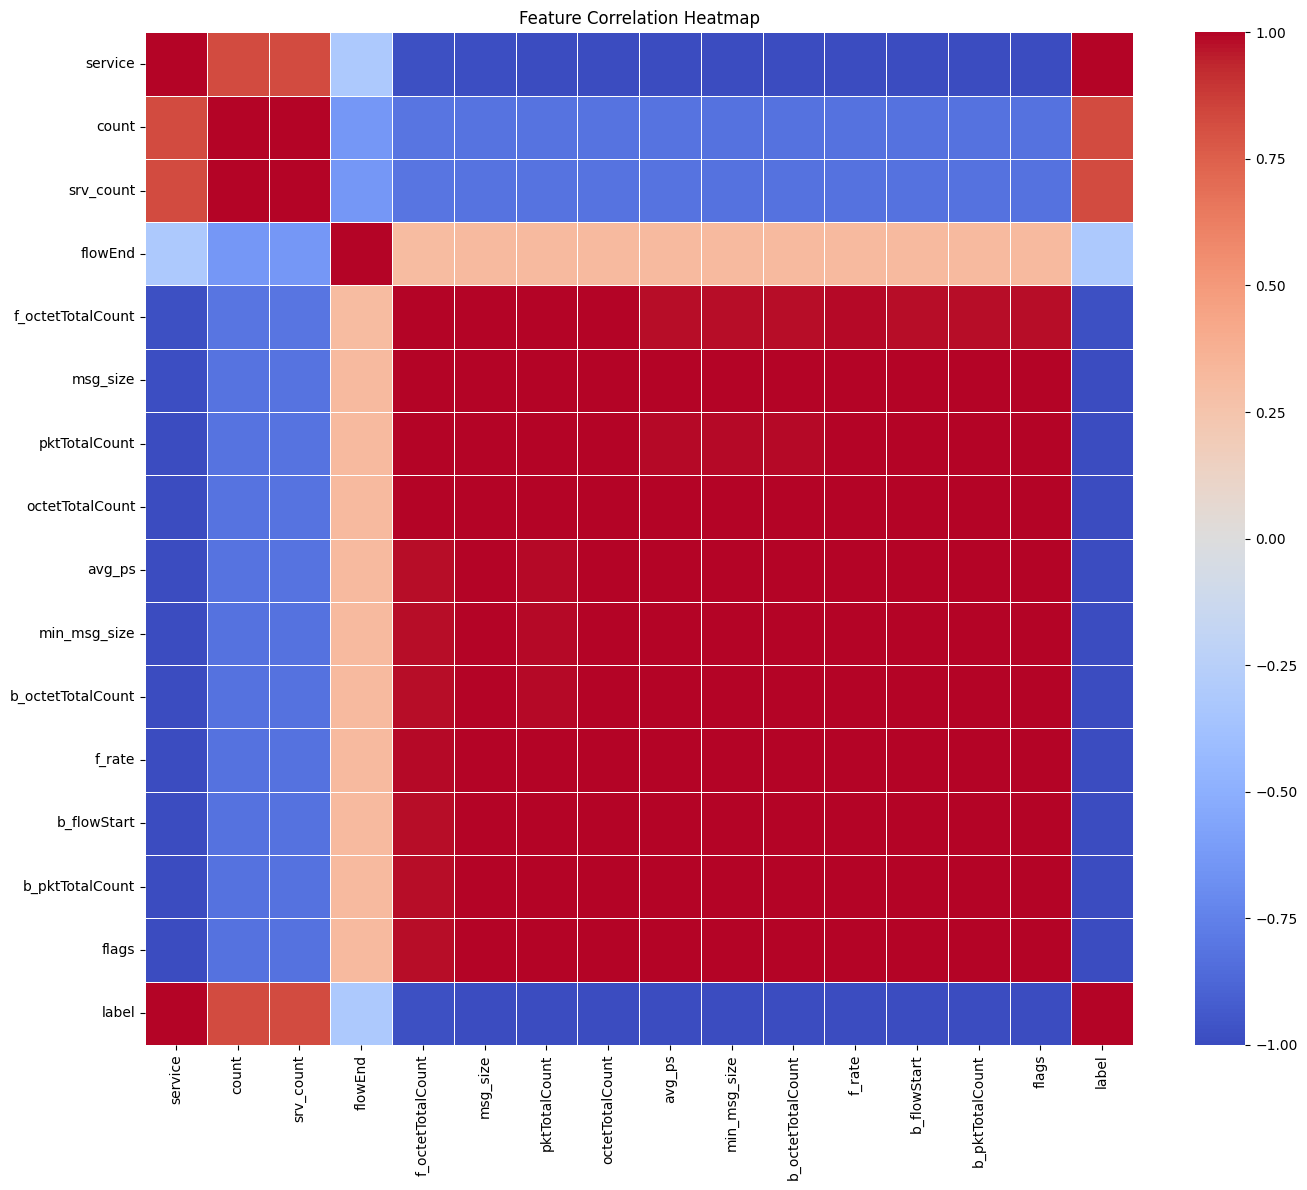

                   service   count  srv_count  flowEnd  f_octetTotalCount  \
service             1.0000  0.8230     0.8230  -0.3180            -0.9832   
count               0.8230  1.0000     1.0000  -0.6366            -0.8105   
srv_count           0.8230  1.0000     1.0000  -0.6366            -0.8105   
flowEnd            -0.3180 -0.6366    -0.6366   1.0000             0.3112   
f_octetTotalCount  -0.9832 -0.8105    -0.8105   0.3112             1.0000   
msg_size           -0.9918 -0.8186    -0.8185   0.3133             0.9928   
pktTotalCount      -0.9943 -0.8194    -0.8193   0.3154             0.9961   
octetTotalCount    -0.9937 -0.8199    -0.8198   0.3143             0.9943   
avg_ps             -0.9935 -0.8202    -0.8202   0.3136             0.9837   
min_msg_size       -0.9944 -0.8207    -0.8207   0.3142             0.9837   
b_octetTotalCount  -0.9944 -0.8208    -0.8208   0.3143             0.9836   
f_rate             -0.9981 -0.8231    -0.8231   0.3159             0.9851   

In [9]:
import seaborn as sns

features_only = ['service', 'count', 'srv_count', 'flowEnd', 'f_octetTotalCount', 'msg_size', 'pktTotalCount', 'octetTotalCount', 'avg_ps', 'min_msg_size', 'b_octetTotalCount', 'f_rate', 'b_flowStart', 'b_pktTotalCount', 'flags', 'label']
corr_matrix = df[features_only].corr().round(4)

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()
print(corr_matrix)

min_max_df = df.describe().loc[['min', 'max']].transpose().round(4)
print(min_max_df)

In [10]:
#handled dimensionality, still handling further
kept_features = ['service', 'count', 'srv_count', 'flowEnd', 'f_octetTotalCount', 'msg_size', 'pktTotalCount', 'octetTotalCount', 'avg_ps', 'min_msg_size', 'b_octetTotalCount', 'f_rate', 'b_flowStart', 'b_pktTotalCount', 'flags', 'label']
df = df[kept_features]
print(df)

min_max_df = df.describe().loc[['min', 'max']].transpose().round(4)
print(min_max_df)

        service  count  srv_count         flowEnd  f_octetTotalCount  \
0             3      0          0 1583854854.0981                125   
1             3      0          0 1583854854.0937                125   
2             1      0          0 1583854854.1164                198   
3             1      0          0 1583854854.1144                198   
4             3      0          0 1583854854.1580                125   
...         ...    ...        ...             ...                ...   
107628        0     12         12 1583862243.6334                197   
107629        0     11         11 1583862247.6594                197   
107630        0     11         11 1583862247.6560                197   
107631        0     10         10 1583862251.6862                197   
107632        0     12         12 1583862251.6862                197   

        msg_size  pktTotalCount  octetTotalCount   avg_ps  min_msg_size  \
0             87              2              219 109.5000   

In [11]:
#view ranges of kept features 

min_max_df = df.describe().loc[['min', 'max']].transpose().round(4)
print(min_max_df)
print(df)

                                       min                       max
service                             0.0000                    3.0000
count                               0.0000                 1216.0000
srv_count                           0.0000                 1216.0000
flowEnd                    1583854854.0937           1583862251.6862
f_octetTotalCount                  86.0000                 3152.0000
msg_size                           32.0000                 2192.0000
pktTotalCount                       1.0000                   17.0000
octetTotalCount                    86.0000                 3314.0000
avg_ps                             86.0000                  490.5000
min_msg_size                       28.0000                  272.0000
b_octetTotalCount                   0.0000                  643.0000
f_rate            8599999999999998976.0000 33799999999999995904.0000
b_flowStart                         0.0000           1583862251.6862
b_pktTotalCount                   

In [12]:
#normalize features to common scale, using min-max scaling
from sklearn import preprocessing

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

scaler = preprocessing.StandardScaler()

X_normalized = scaler.fit_transform(X)

X_normalized = pd.DataFrame(X_normalized, columns=X.columns)

X_normalized['label'] = y.values
df = X_normalized
print(df.describe().loc[['min','max']].transpose())





                      min     max
service           -1.4874  0.6729
count             -1.3033  3.1686
srv_count         -1.3033  3.1686
flowEnd           -1.2028  2.8615
f_octetTotalCount -0.6628 57.9531
msg_size          -0.6692 23.1053
pktTotalCount     -0.6700 33.6848
octetTotalCount   -0.6703 24.7432
avg_ps            -0.6705  8.6329
min_msg_size      -0.8060  7.4335
b_octetTotalCount -0.6710  7.8774
f_rate            -0.6729  4.2218
b_flowStart       -0.6733  1.4853
b_pktTotalCount   -0.6733  1.4853
flags             -0.6734  1.4849
label              0.0000  1.0000



Explained variance ratio for each principal component (all components):
  Component 1: 0.9034
  Component 2: 0.0807
  Component 3: 0.0143
  Component 4: 0.0015
  Component 5: 0.0001
  Component 6: 0.0000
  Component 7: 0.0000
  Component 8: 0.0000
  Component 9: 0.0000
  Component 10: 0.0000
  Component 11: 0.0000
  Component 12: 0.0000
  Component 13: 0.0000
  Component 14: 0.0000
  Component 15: 0.0000
  Component 16: 0.0000

Cumulative explained variance for all components:
  Up to Component 1: 0.9034
  Up to Component 2: 0.9840
  Up to Component 3: 0.9983
  Up to Component 4: 0.9998
  Up to Component 5: 0.9999
  Up to Component 6: 1.0000
  Up to Component 7: 1.0000
  Up to Component 8: 1.0000
  Up to Component 9: 1.0000
  Up to Component 10: 1.0000
  Up to Component 11: 1.0000
  Up to Component 12: 1.0000
  Up to Component 13: 1.0000
  Up to Component 14: 1.0000
  Up to Component 15: 1.0000
  Up to Component 16: 1.0000

Minimum number of components to explain at least 95% variance

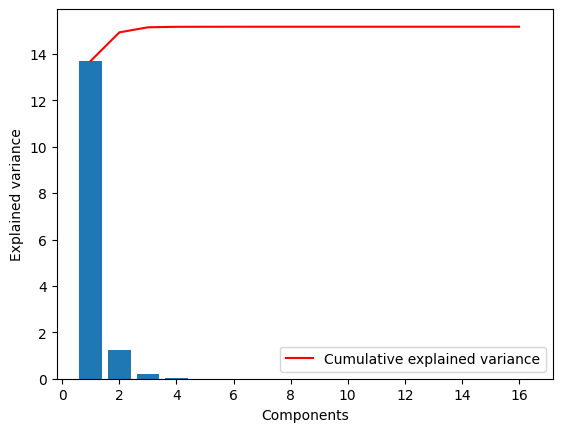

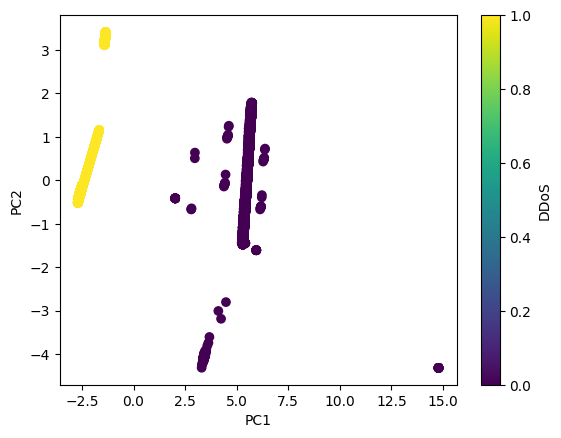

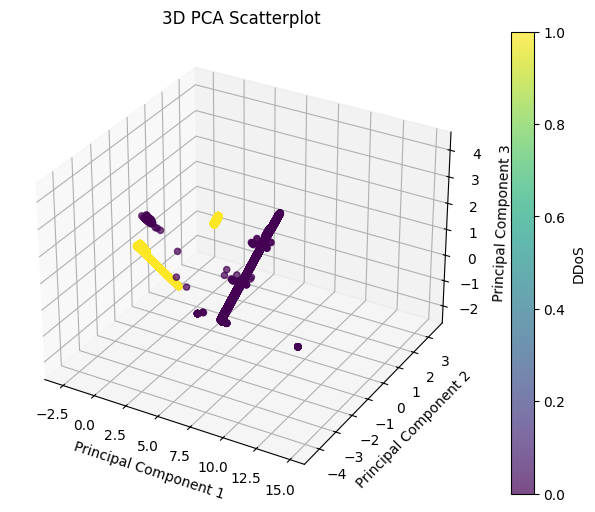

In [13]:
#apply PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



pca1 = PCA()
pca2 = PCA(0.95)
X_pca1 = pca1.fit_transform(X_train)
X_pca2 = pca2.fit_transform(X_train)

print("\nExplained variance ratio for each principal component (all components):")
for i, ratio in enumerate(pca1.explained_variance_ratio_, start=1):
    print(f"  Component {i}: {ratio:.4f}")

cumulative_variance = np.cumsum(pca1.explained_variance_ratio_)
print("\nCumulative explained variance for all components:")
for i, cumulative in enumerate(cumulative_variance, start=1):
    print(f"  Up to Component {i}: {cumulative:.4f}")

print(f"\nMinimum number of components to explain at least 95% variance: {pca2.n_components_}")
print("Explained variance ratio for these selected components:")
for i, ratio in enumerate(pca2.explained_variance_ratio_, start=1):
    print(f"  Component {i}: {ratio:.4f}")

plt.figure()
plt.bar(range(1, len(pca1.explained_variance_)+1),pca1.explained_variance_)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1, len(pca1.explained_variance_)+1),
         np.cumsum(pca1.explained_variance_),
         c='red',
         label="Cumulative explained variance")
plt.legend(loc='lower right')
plt.show()

pca2c = PCA(n_components=2)
pca3c = PCA(n_components=3)
X_pca2c = pca2c.fit_transform(X_train)
X_pca3c = pca3c.fit_transform(X_train)

plt.figure()
scatter = plt.scatter(X_pca2c[:, 0], X_pca2c[:, 1], c=y_train)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='DDoS')
plt.show()


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter3d = ax.scatter(X_pca3c[:, 0], X_pca3c[:, 1], X_pca3c[:, 2], c=y_train, cmap='viridis', alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Scatterplot')
fig.colorbar(scatter3d, ax=ax, label='DDoS')
plt.show()



Key features for PC1 :
f_rate              0.2689
b_octetTotalCount   0.2687
b_flowStart         0.2687
flags               0.2687
b_pktTotalCount     0.2687
avg_ps              0.2686
min_msg_size        0.2686
service             0.2684
octetTotalCount     0.2681
msg_size            0.2680
pktTotalCount       0.2673
f_octetTotalCount   0.2647
count               0.2352
srv_count           0.2352
label               0.1245
flowEnd             0.1058
Name: PC1, dtype: float64 

Key features for PC2 :
flowEnd             0.7952
srv_count           0.3801
count               0.3800
avg_ps              0.0831
msg_size            0.0827
b_octetTotalCount   0.0826
min_msg_size        0.0824
octetTotalCount     0.0815
f_rate              0.0805
f_octetTotalCount   0.0792
flags               0.0787
b_pktTotalCount     0.0787
b_flowStart         0.0787
pktTotalCount       0.0783
service             0.0772
label               0.0365
Name: PC2, dtype: float64 



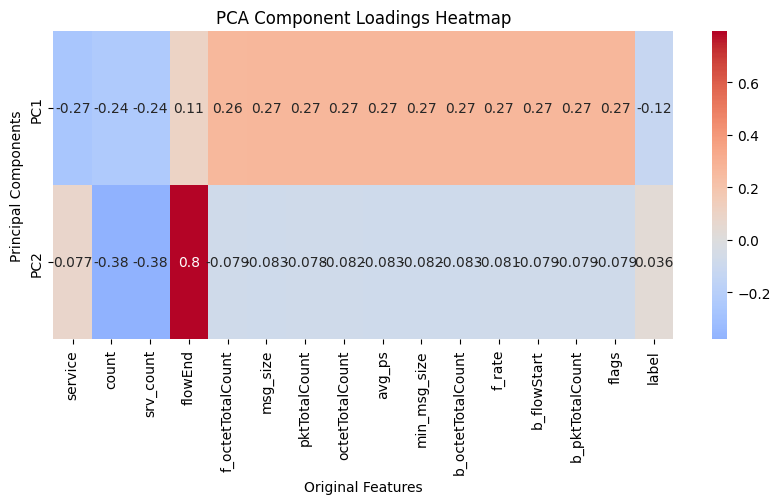

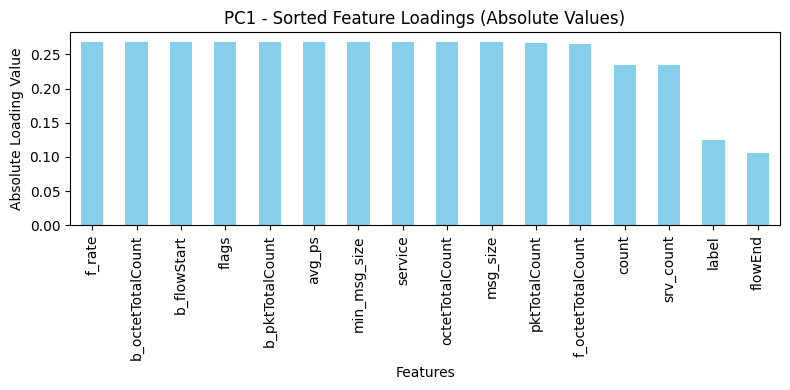

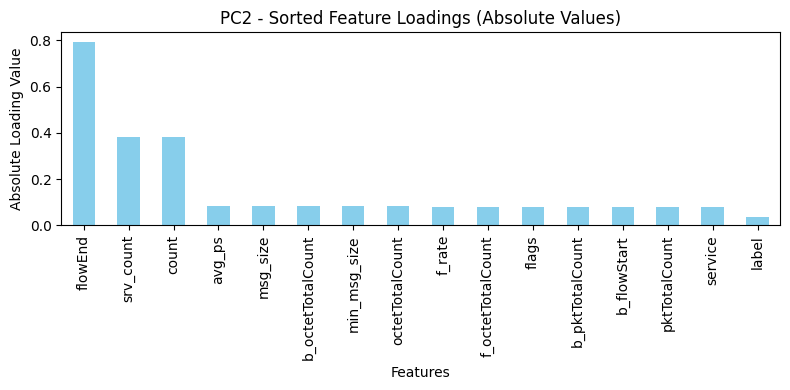

In [14]:
"""
PCA loadings are the coefficients of the linear combination of 
the original variables from which the principal components (PCs) are constructed.
describe how much each variable contributes to a particular principal component. 
Large loadings (positive or negative) indicate that a particular variable strongly 
relates to a particular principal component.
"""

loadings_df = pd.DataFrame(pca2.components_, columns=X.columns, index=['PC1', 'PC2'])

# For each pc sort features by absolute loading values
for pc in loadings_df.index:
    sorted_loadings = loadings_df.loc[pc].abs().sort_values(ascending=False)
    print(f"Key features for {pc} :")
    print(sorted_loadings, "\n")

#heatmap for a visual interpretation of the loadings
plt.figure(figsize=(10, 4))
sns.heatmap(loadings_df, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Component Loadings Heatmap")
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.show()

#bar charts for each principal component's loadings
for pc in loadings_df.index:
    plt.figure(figsize=(8, 4))
    sorted_features = loadings_df.loc[pc].abs().sort_values(ascending=False)
    sorted_features.plot(kind='bar', color='skyblue')
    plt.title(f"{pc} - Sorted Feature Loadings (Absolute Values)")
    plt.xlabel("Features")
    plt.ylabel("Absolute Loading Value")
    plt.tight_layout()
    plt.show()

In [15]:
print(df)

        service   count  srv_count  flowEnd  f_octetTotalCount  msg_size  \
0        0.6729 -1.3033    -1.3033  -1.2028             0.0828   -0.0639   
1        0.6729 -1.3033    -1.3033  -1.2028             0.0828   -0.0639   
2       -0.7673 -1.3033    -1.3033  -1.2028             1.4784    1.9173   
3       -0.7673 -1.3033    -1.3033  -1.2028             1.4784    1.9173   
4        0.6729 -1.3033    -1.3033  -1.2028             0.0828   -0.0639   
...         ...     ...        ...      ...                ...       ...   
107573  -1.4874 -1.2592    -1.2592   2.8571             1.4593    1.4771   
107574  -1.4874 -1.2628    -1.2628   2.8593             1.4593    1.4661   
107575  -1.4874 -1.2628    -1.2628   2.8593             1.4593    1.4771   
107576  -1.4874 -1.2665    -1.2665   2.8615             1.4593    1.4771   
107577  -1.4874 -1.2592    -1.2592   2.8615             1.4593    1.4771   

        pktTotalCount  octetTotalCount  avg_ps  min_msg_size  \
0              1.4772  

In [16]:
label_0 = df[df['label'] == 0]
label_1 = df[df['label'] == 1]
label_0_samples = label_0.sample(n = 33000, random_state= 42)
label_1_samples = label_1.sample(n = 33000, random_state = 42)

balanced_df = pd.concat([label_0_samples, label_1_samples])
df_balanced = balanced_df.sample(frac = 1, random_state= 42).reset_index(drop=True)

df = df_balanced
print(df)

       service   count  srv_count  flowEnd  f_octetTotalCount  msg_size  \
0      -1.4874 -1.2555    -1.2555   0.9273             1.4593    1.4771   
1       0.6729  0.8334     0.8333  -0.5348            -0.6628   -0.6692   
2       0.6729  0.8554     0.8554  -0.5652            -0.6628   -0.6692   
3      -1.4874 -1.2114    -1.2114  -0.1597             1.4593    1.4771   
4       0.6729  0.8371     0.8370  -0.4615            -0.6628   -0.6692   
...        ...     ...        ...      ...                ...       ...   
65995   0.6729  0.7745     0.7745  -0.4549            -0.6628   -0.6692   
65996  -1.4874 -1.1819    -1.1819   2.0031             1.4593    1.4661   
65997   0.6729  0.8260     0.8260  -0.4764            -0.6628   -0.6692   
65998  -1.4874 -1.2261    -1.2261  -0.0066             1.4593    1.4771   
65999  -1.4874 -1.2261    -1.2261  -1.0115             1.4593    1.4661   

       pktTotalCount  octetTotalCount  avg_ps  min_msg_size  \
0             1.4772           1.479

In [17]:
df.to_csv('cleaned_data_for_OCPUA.csv', index=False)